# EEG Feature Extraction 2: Parameterizing PSDs and Modeling
In 2008, a BCI Competition was held on EEG datasets to find the best ML and statistical algorithms to differentiate different classes of neural data. The BCI Competition IV 2b is a motor imagery dataset with eye artifact data, making it a very realistic dataset. The subjects are prompted to imagine left vs right hand movement and the EEG + EOG signals for each trial are collected. We here have provided a simpler version of the dataset in CSV format for you to get started with. 

This notebook will introduce a couple more feature extraction methods, provide some guidance in dimensionality reduction, and show how these features can be used in a model to predict classes. 

Terminology: <br>
- <b>Fitting Oscillations and One Over F (FOOOF)</b>: A technique that fits a 1/f model to the Power Spectrum Density to allow for more features to be extracted. 
- <b>Modeling and NN</b>: Machine learning techniques that can help us classify our data. 

Experiment Setup: http://www.bbci.de/competition/iv/desc_2b.pdf <br>
FOOOF: https://fooof-tools.github.io/fooof/index.html


## Imports

In [1]:
import sys
sys.setrecursionlimit(10000)
from pathlib import Path # For making paths compatible on Windows and Macs
import pickle # For loading and creating pickle files
import pandas as pd # For working with DataFrames 
import numpy as np # For ease of array manipulation, stats, and some feature extraction
import matplotlib.pyplot as plt # For plotting pretty plots :) 
import scipy.signal as signal # For calculating PSDs and plotting spectrograms
!pip install neurodsp
from neurodsp.spectral import compute_spectrum # For smoothed PSD computation
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time # For neurodsp features

# Import required code for visualizing example models
!pip install fooof
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.annotate import plot_annotated_model

# Import machine learning models
# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
# neural network imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten

     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 112 kB 14.9 MB/s 


## Load Data
Loading compeititon data from Kaggles, custom feature extraction files from Github

*   [Mount Google Drive](https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa) </br>
*   [Structure Colab Project](https://neptune.ai/blog/google-colab-dealing-with-files)
*   [Git LFS](https://stackoverflow.com/questions/54451856/how-can-i-tell-if-a-file-will-begrrectly)
*   [Git Detached Head State](https://www.cloudbees.com/blog/git-detached-head)
*   [Download data from Kaggles on Colab](https://www.kaggle.com/c/ucsd-neural-data-challenge/data)



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd '/content/gdrive/MyDrive/Neural Data Competition'

/content/gdrive/MyDrive/Neural Data Competition


Load epoched data

In [6]:
# These + epoched_test.pkl are the epochs that will be used in accuracy evaluation
epoch_df_filename = Path("./data/epoched_train.pkl")
eeg_epoch_full_df = pd.read_pickle(epoch_df_filename)
eeg_epoch_full_df.head(2)

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."


Load previous created features

In [7]:
W1_feature_df_filename = Path("./features/W1_feature_df.pkl")
W1_feature_df = pd.read_pickle(W1_feature_df_filename)
W1_feature_df.head(2)

,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)"
0,0,0.19038,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.24095,0.192458,0.013933,0.005190,0.026448,-0.045572
1,1,0.33806,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.25083,0.333788,-0.131600,-0.021204,-0.003139,0.155944


## Constants

In [8]:
eeg_fs = 250 # Data was recorded at 250 Hz
eeg_chans = ["C3", "Cz", "C4"] # 10-20 system 
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"] 
all_chans = eeg_chans + eog_chans
event_types = {0:"left", 1:"right"}

## Helper functions

In [9]:
# Get Frequencies and mean PSDs from EEG data - this yeilds smoother PSDs because it averages the PSDs made from sliding windows. 
def getMeanFreqPSD(eeg_data, fs=eeg_fs):
    freq_mean, psd_mean = compute_spectrum(eeg_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
    return freq_mean, psd_mean

# Let's add a couple more features! 

## NeuroDSP Alpha Instantaneous Amplitude median
Perhaps this can help account for large outliers and noise in the alpha power. 

In [10]:
alpha_range = (7, 12)
alpha_amps = {}
for i in range(0, len(eeg_epoch_full_df)): 
    for ch in eeg_chans: 
        amp = amp_by_time(eeg_epoch_full_df[ch][i][:], eeg_fs, alpha_range)
        key = ch + "_" + str(alpha_range) + "_inst_med"
        if key not in alpha_amps: 
            alpha_amps[key] = list()
        alpha_amps[key].append(np.nanmedian(amp))

alpha_med_df = pd.DataFrame(alpha_amps)
display(alpha_med_df.head(2))

feature_df = pd.concat([W1_feature_df, alpha_med_df], axis=1)
display(feature_df.head(2))


,"C3_(7, 12)_inst_med","Cz_(7, 12)_inst_med","C4_(7, 12)_inst_med"
0,1.380980,1.525609,1.393794
1,0.883383,1.970205,1.079447


,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)","C3_(7, 12)_inst_med","Cz_(7, 12)_inst_med","C4_(7, 12)_inst_med"
0,0,0.19038,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.24095,0.192458,0.013933,0.005190,0.026448,-0.045572,1.380980,1.525609,1.393794
1,1,0.33806,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.25083,0.333788,-0.131600,-0.021204,-0.003139,0.155944,0.883383,1.970205,1.079447


## FOOOF (i.e. Fitting Oscillations and One Over F) 
PSDs are highly analyzed in neural data, and FOOOF helps parameterize some qualities of these PSDs that can allow us to consider more features of our data. In particular, this package will take a PSD and try to fit a 1/f aperiodic line to represent the base "noise" and then fit more curves above the line to outline the periodic activity. This can be helpful in being more specific about the oscillatory behavior in the neural data. 

Donoghue T, Haller M, Peterson E, Varma P, Sebastian P, Gao R, Noto T, Lara AH, Wallis JD,
Knight RT, Shestyuk A, Voytek B. Parameterizing neural power spectra into periodic
and aperiodic components. Nature Neuroscience (in press)

They have great documentation and tutorials for fine-tuning the models to best parameterize your data on their website: https://fooof-tools.github.io/fooof/auto_tutorials/index.html 

### Let's first understand visually what the model does: 
Here we can see what the different features of the PSDs are identified. 

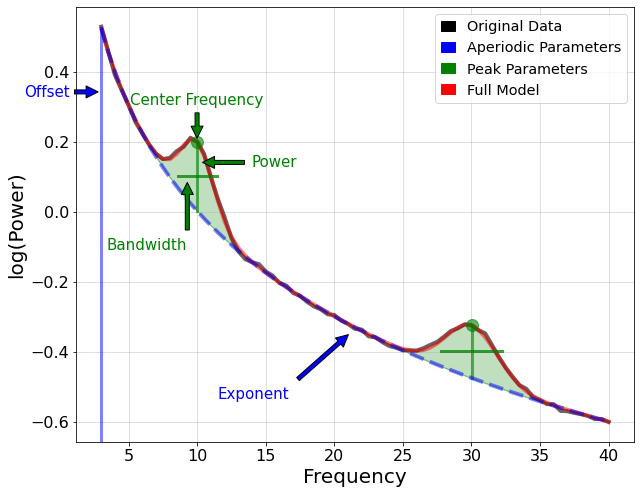

In [11]:
# Set random seed, for consistency generating simulated data
set_random_seed(10)

# Simulate example power spectra
freqs1, powers1 = gen_power_spectrum([3, 40], [1, 1],
                                     [[10, 0.2, 1.25], [30, 0.15, 2]])

# Initialize power spectrum model objects and fit the power spectra
fm1 = FOOOF(min_peak_height=0.05, verbose=False)
fm1.fit(freqs1, powers1)

plot_annotated_model(fm1, annotate_aperiodic=True)

### Let's see what the model predicts of one EEG trace

In [12]:
# Constants 
freq_range = [1, 40]

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.0098, 1.0408                                          
                                                                                                  
                                       6 peaks were found:                                        
          

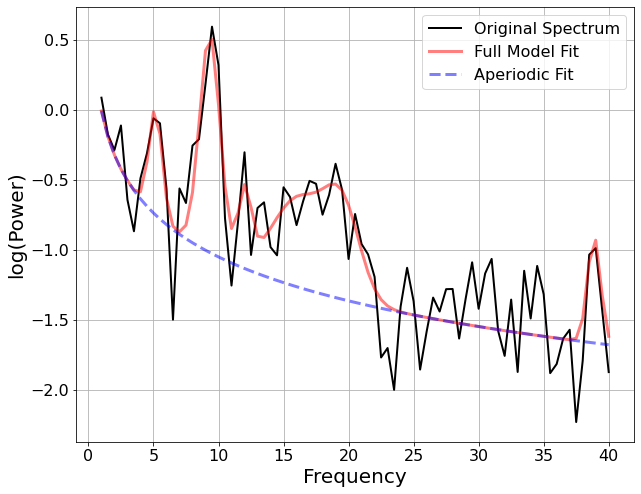

In [13]:
# Initialize a FOOOF object
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)

# Get the PSD of our EEG Signal
sig = eeg_epoch_full_df['Cz'][0]
freq, psd = getMeanFreqPSD(sig)

fm.add_data(freq, psd, freq_range)

fm.fit()
fm.report()

### Let's see what the model detects from the averaged PSDs that we saw before

In [14]:
# Get PSD averages for each channel for each event type (0=left or 1=right)
psd_averages_by_type = {}

for event_type in event_types.keys(): 
    psds_only_one_type={}
    freqs_only_one_type={}
    for i, row in eeg_epoch_full_df[eeg_epoch_full_df["event_type"] == event_type].iterrows(): 
        for ch in eeg_chans: 
            if ch not in psds_only_one_type: 
                psds_only_one_type[ch] = list()
                freqs_only_one_type[ch] = list()
            f, p = getMeanFreqPSD(row[ch])
            psds_only_one_type[ch].append(p)
            freqs_only_one_type[ch].append(f)
    avg_psds_one_type = {}
    for ch in eeg_chans:
        psds_only_one_type[ch] = np.array(psds_only_one_type[ch])
        avg_psds_one_type[ch] = np.mean(psds_only_one_type[ch], axis=0)
    psd_averages_by_type[event_type] = dict(avg_psds_one_type)
    

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.3723, 1.1075                                          
                                                                                                  
                                       1 peaks were found:                                        
          

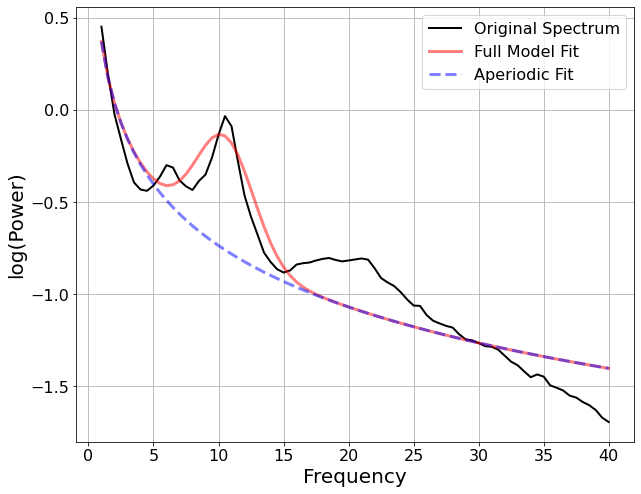

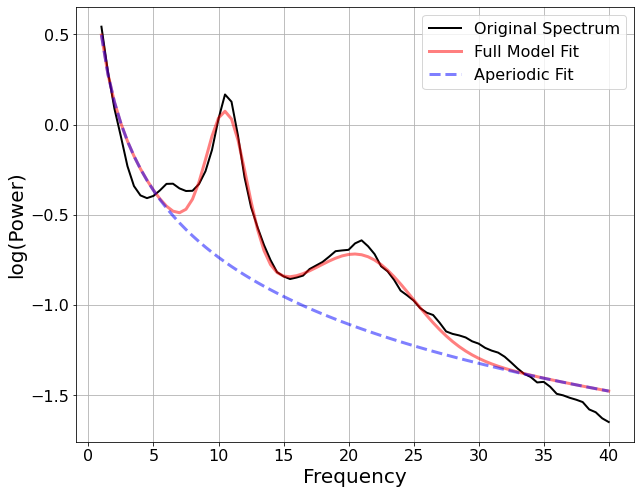

In [15]:
# Visualize the parameters in these two classes of C4 activity
fm_left_C4 = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)
fm_left_C4.add_data(freqs_only_one_type[eeg_chans[0]][0], psd_averages_by_type[0]['C4'], freq_range)
fm_left_C4.fit()
fm_left_C4.report()

fm_right_C4 = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)
fm_right_C4.add_data(freqs_only_one_type[eeg_chans[0]][0], psd_averages_by_type[1]['C4'], freq_range)
fm_right_C4.fit()
fm_right_C4.report()

In [16]:
# Calculate central freq, alpha power, and bandwidth for each channel and each trial
# This cell takes a few minutes to run (~8 mins on my computer). There are 3680 trials in the training data. 

# Initialize a fooof object
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)

# Some will not have alpha peaks, use these variables to keep track
num_with_alpha = 0
num_without_alpha = 0
fooof_parameters = {}
for i in range(len(eeg_epoch_full_df)):
    # Print the trial number every 100 to make sure we're making progress
    if i % 100 == 0 :
        print(i)
    for ch in eeg_chans:
        # Determine the key
        CF_key = ch + "_alpha_central_freq"
        PW_key = ch + "_alpha_power"
        BW_key = ch + "_alpha_band_width"
        if CF_key not in fooof_parameters: 
            fooof_parameters[CF_key] = []
        if PW_key not in fooof_parameters: 
            fooof_parameters[PW_key] = []
        if BW_key not in fooof_parameters: 
            fooof_parameters[BW_key] = []
        
        # Calculate the PSD for the desired signal
        sig = eeg_epoch_full_df[ch][i]
        freq, psd = getMeanFreqPSD(sig)
        
        # Set the frequency and spectral data into the FOOOF model and get peak params
        fm.add_data(freq, psd, freq_range)
        fm.fit()
        peak_params = fm.peak_params_
        
        # Only select the peaks within alpha power
        peak_params_alpha = []
        for param in peak_params: 
            if (param[0] > alpha_range[0]) and (param[0] < alpha_range[1]): 
                peak_params_alpha.append(param)
        
        # Take the average if there are multiple peaks detected, otherwise 0 everything
        means = []
        if len(peak_params_alpha) > 0: 
            num_with_alpha += 1
            means = np.mean(peak_params_alpha, axis=0)
        else :
            num_without_alpha += 1
            means = [0, 0, 0]
        
        fooof_parameters[CF_key].append(means[0])
        fooof_parameters[PW_key].append(means[1])
        fooof_parameters[BW_key].append(means[2])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


In [17]:
# Concatenate 
fooof_parameters_df = pd.DataFrame(fooof_parameters)
display(fooof_parameters_df.head(5))

feature_df = pd.concat([W1_feature_df, alpha_med_df, fooof_parameters_df], axis=1)
display(feature_df.head(2))
print("% with alpha:", num_with_alpha / (num_with_alpha + num_without_alpha))

,C3_alpha_central_freq,C3_alpha_power,C3_alpha_band_width,Cz_alpha_central_freq,Cz_alpha_power,Cz_alpha_band_width,C4_alpha_central_freq,C4_alpha_power,C4_alpha_band_width
0,10.767450,1.694548,1.099598,9.333142,1.528012,1.553793,9.197939,0.704313,1.492050
1,0.000000,0.000000,0.000000,10.322405,1.303298,1.314306,11.534744,0.636638,1.541322
2,11.431135,1.128085,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,9.036130,0.714929,1.806071,9.671330,1.030771,2.681447,0.000000,0.000000,0.000000
4,9.886993,0.866017,1.459396,9.659022,1.337730,1.804279,0.000000,0.000000,0.000000


,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)","C3_(7, 12)_inst_med","Cz_(7, 12)_inst_med","C4_(7, 12)_inst_med",C3_alpha_central_freq,C3_alpha_power,C3_alpha_band_width,Cz_alpha_central_freq,Cz_alpha_power,Cz_alpha_band_width,C4_alpha_central_freq,C4_alpha_power,C4_alpha_band_width
0,0,0.19038,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.24095,0.192458,0.013933,0.005190,0.026448,-0.045572,1.380980,1.525609,1.393794,10.76745,1.694548,1.099598,9.333142,1.528012,1.553793,9.197939,0.704313,1.492050
1,1,0.33806,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.25083,0.333788,-0.131600,-0.021204,-0.003139,0.155944,0.883383,1.970205,1.079447,0.00000,0.000000,0.000000,10.322405,1.303298,1.314306,11.534744,0.636638,1.541322


% with alpha: 0.8690217391304348


In [18]:
# Save it so you don't need to spend extra time rerunning the heavy computation cell from above. 
feature_df.to_pickle("./features/W2_feature_df.pkl")

## Now you have many features to put into your Machine Learning algorithm or plot with statistics to find differences between the classes! 

In [19]:
import sys
sys.setrecursionlimit(10000)
# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
# neural network imports
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, SpatialDropout2D, ReLU, BatchNormalization
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
import time
import tensorflow as tf
import numpy as np
from statistics import mean 

In [20]:
feature_df = pickle.load(open("features/W1_feature_df.pkl", "rb"))
feature_df.head()

,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)"
0,0,0.190380,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.240950,0.192458,0.013933,0.005190,0.026448,-0.045572
1,1,0.338060,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.250830,0.333788,-0.131600,-0.021204,-0.003139,0.155944
2,0,0.234302,0.101459,0.162443,0.501796,0.191182,0.157964,0.189180,0.461674,0.235221,0.127780,0.156822,0.480177,0.202192,0.342156,0.266110,-0.000919,-0.026321,0.005621,0.021619
3,1,0.247263,0.139796,0.177430,0.435511,0.316947,0.093709,0.204395,0.384950,0.289331,0.099774,0.166477,0.444418,0.320994,0.243432,0.224504,-0.042068,0.040023,0.010953,-0.008907
4,1,0.249109,0.107688,0.202389,0.440814,0.189605,0.109879,0.284962,0.415554,0.249175,0.093967,0.197290,0.459568,0.244292,0.264417,0.204467,-0.000065,0.013721,0.005098,-0.018754


In [21]:
# Check for null 
null_df = pd.DataFrame(feature_df.isnull().mean(), columns=["null %"])
null_cols = null_df[null_df["null %"] > 0]
null_df

,null %
y,0.0
"C3_(0.5, 4)",0.0
"C3_(4, 7)",0.0
"C3_(7, 12)",0.0
"C3_(12, 30)",0.0
"Cz_(0.5, 4)",0.0
"Cz_(4, 7)",0.0
"Cz_(7, 12)",0.0
"Cz_(12, 30)",0.0
"C4_(0.5, 4)",0.0


In [22]:
# View cleaned dataframe
cleaned_feature_df = feature_df.drop(list(null_cols.index), axis=1)
cleaned_feature_df.head()

,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)",C3_theta_beta,Cz_theta_beta,C4_theta_beta,"C3_C4_diff_(0.5, 4)","C3_C4_diff_(4, 7)","C3_C4_diff_(7, 12)","C3_C4_diff_(12, 30)"
0,0,0.190380,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032,0.222452,0.240950,0.192458,0.013933,0.005190,0.026448,-0.045572
1,1,0.338060,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698,0.175444,0.250830,0.333788,-0.131600,-0.021204,-0.003139,0.155944
2,0,0.234302,0.101459,0.162443,0.501796,0.191182,0.157964,0.189180,0.461674,0.235221,0.127780,0.156822,0.480177,0.202192,0.342156,0.266110,-0.000919,-0.026321,0.005621,0.021619
3,1,0.247263,0.139796,0.177430,0.435511,0.316947,0.093709,0.204395,0.384950,0.289331,0.099774,0.166477,0.444418,0.320994,0.243432,0.224504,-0.042068,0.040023,0.010953,-0.008907
4,1,0.249109,0.107688,0.202389,0.440814,0.189605,0.109879,0.284962,0.415554,0.249175,0.093967,0.197290,0.459568,0.244292,0.264417,0.204467,-0.000065,0.013721,0.005098,-0.018754


In [23]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(cleaned_feature_df.drop("y", axis=1), cleaned_feature_df["y"])
x_train.shape, x_test.shape

((2760, 19), (920, 19))

# Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression

In [24]:
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
train_preds = log_model.predict(x_train)
test_preds = log_model.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 0.661957
Testing Accuracy: 0.655435


# Decision Tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier

In [25]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(x_train, y_train)
train_preds = dtree_model.predict(x_train)
test_preds = dtree_model.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 1.000000
Testing Accuracy: 0.601087


# Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier

In [26]:
forest_model = RandomForestClassifier()
forest_model.fit(x_train, y_train)
train_preds = forest_model.predict(x_train)
test_preds = forest_model.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 1.000000
Testing Accuracy: 0.646739


# AdaBoost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier

In [27]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(x_train, y_train)
train_preds = adaboost_model.predict(x_train)
test_preds = adaboost_model.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 0.696739
Testing Accuracy: 0.651087


# Support Vector Machine

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC


In [28]:
svc_model = SVC()
svc_model.fit(x_train, y_train)
train_preds = svc_model.predict(x_train)
test_preds = svc_model.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 0.681159
Testing Accuracy: 0.656522


# Grid Search with Cross Validation
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV

Here we will use the GridSearchCV function to find the most optimal set of hyperparameters for training the model.

In [29]:
adaboost_cv = GridSearchCV(AdaBoostClassifier(),
                          param_grid={"n_estimators":range(30, 101, 10),
                                     "learning_rate":[1, 0.1, 0.01]})
adaboost_cv.fit(x_train, y_train)
best_model = adaboost_cv.best_estimator_
best_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)

In [30]:
train_preds = best_model.predict(x_train)
test_preds = best_model.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 0.678986
Testing Accuracy: 0.678261


## Load epoched EEG data for Neural Net training

In [31]:
train_df = pickle.load(open("data/epoched_train.pkl", "rb"))
train_df.head()

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."
2,B0101T,251268.0,0,"[-0.2380407415884641, -2.0721751735713743, -2....","[2.825970855268177, 3.308155947203784, 1.83718...","[-0.9155413138017852, -0.5645838101777675, -2....","[-8.331425955596247, -15.7778286411841, -1.922...","[-1.9226367589837492, -9.552147707331956, -6.6...","[-8.453498130769818, -15.228503852903028, -7.1..."
3,B0101T,259416.0,1,"[-0.5554283970397498, -2.926680399786373, -4.9...","[5.743495841916532, 4.785229266803998, 3.40581...","[0.9155413138017852, 1.541161211566339, 1.0284...","[6.6224155031662475, 3.1128404669260696, 11.74...","[-1.6174563210498203, -2.349889372091249, 9.00...","[-2.2278171969176768, 2.349889372091249, 12.90..."
4,B0101T,294924.0,1,"[-2.8961623559929808, -2.352941176470588, -1.7...","[2.8442816815442127, 2.7557793545433737, 2.075...","[-0.8331425955596247, -0.32349126420996416, 0....","[7.2938124666208894, -2.655069810025177, 7.110...","[7.934691386282138, 0.18310826276035705, 12.93...","[14.740215152208743, 6.3172350652323175, 15.47..."


In [32]:
# View shapes of numpy arrays
train_df.drop(["patient_id", "start_time", "event_type"], axis=1).iloc[0].apply(lambda x:x.shape)

C3          (1000,)
Cz          (1000,)
C4          (1000,)
EOG:ch01    (1000,)
EOG:ch02    (1000,)
EOG:ch03    (1000,)
Name: 0, dtype: object

# Neural Networks
Looking at the raw data's shapes above, we can concatenate the 6 channels to create an input of 6000 values into a basic neural network

In [33]:
# Concatenate all the arrays and convert the dataframe to numpy array
X = train_df.drop(["patient_id", "start_time", "event_type"], axis=1).apply(lambda x:np.concatenate(x), axis=1)
X = np.array(X.values.tolist())
# Convert labels to numpy array
Y = train_df["event_type"].values.astype(float)
X.shape, Y.shape

((3680, 6000), (3680,))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)
x_train.shape, x_test.shape

((2760, 6000), (920, 6000))

In [35]:
# Build model using keras's Sequential API
neural_network = keras.Sequential([Dense(2048, activation="relu"),
                                   Dense(1024, activation="relu"),
                                   Dropout(0.25),
                                   Dense(512, activation="relu"),
                                   Dense(128, activation="relu"),
                                   Dropout(0.15),
                                   Dense(1, activation="sigmoid")])
# Define the optimizer, learning rate, loss function, and metrics
opt = Adam(lr=0.0007)
neural_network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
history = neural_network.fit(x_train, y_train, epochs=15, batch_size=64)

Epoch 1/15
44/44 [==============================] - 2s 4ms/step - loss: 2.2934 - accuracy: 0.6058
Epoch 2/15
44/44 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.7120
Epoch 3/15
44/44 [==============================] - 0s 5ms/step - loss: 0.4798 - accuracy: 0.7793
Epoch 4/15
44/44 [==============================] - 0s 4ms/step - loss: 0.3505 - accuracy: 0.8533
Epoch 5/15
44/44 [==============================] - 0s 4ms/step - loss: 0.8448 - accuracy: 0.8373
Epoch 6/15
44/44 [==============================] - 0s 4ms/step - loss: 0.3304 - accuracy: 0.8924
Epoch 7/15
44/44 [==============================] - 0s 4ms/step - loss: 0.3794 - accuracy: 0.8880
Epoch 8/15
44/44 [==============================] - 0s 4ms/step - loss: 0.2398 - accuracy: 0.9312
Epoch 9/15
44/44 [==============================] - 0s 4ms/step - loss: 0.4355 - accuracy: 0.8543
Epoch 10/15
44/44 [==============================] - 0s 5ms/step - loss: 0.2130 - accuracy: 0.9348
Epoch 11/15
44/44 [

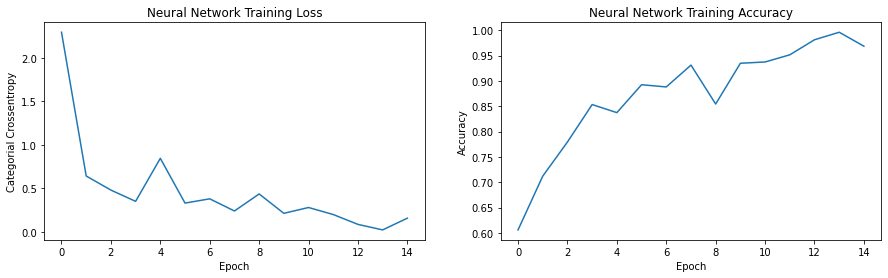

In [37]:
# Plot training progress
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(history.history["loss"])
axs[0].set_title("Neural Network Training Loss")
axs[0].set_ylabel("Categorial Crossentropy")
axs[0].set_xlabel("Epoch")
axs[1].plot(history.history["accuracy"])
axs[1].set_title("Neural Network Training Accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch");

In [38]:
# Evaluate on test set
neural_network.evaluate(x_test, y_test);

29/29 [==============================] - 0s 3ms/step - loss: 1.2706 - accuracy: 0.6967


# Convolutional Neural Networks
To use a convolutional neural network architecture, we will instead stack the 1000 dimensional arrays to make 1000 x 6 matrices that can the model can perform convolution on.


In [39]:
# Stack arrays to form 2d matrices for each trial
X = train_df.drop(["patient_id", "start_time", "event_type"], axis=1).apply(lambda x:np.stack(x, axis=-1), axis=1)
X = np.array(X.values.tolist())
X = X.reshape(list(X.shape)+[1])
# Convert labels to numpy array
Y = train_df["event_type"].values.astype(float)
X.shape, Y.shape

((3680, 1000, 6, 1), (3680,))

In [40]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y)
x_train.shape, x_test.shape

((2760, 1000, 6, 1), (920, 1000, 6, 1))

In [41]:
# Build model using keras's Sequential API
cnn = keras.Sequential([Conv2D(32, (3, 3), activation="relu", input_shape=(1000, 6, 1)),
                        Conv2D(64, (3, 3), activation="relu"),
                        Flatten(),
                        Dense(256, activation="relu"),
                        Dropout(0.2),
                        Dense(128, activation="relu"),
                        Dense(1, activation="sigmoid")])
# Define the optimizer, learning rate, loss function, and metrics
opt = Adam(lr=0.001)
cnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [42]:
history = cnn.fit(x_train, y_train, epochs=8, batch_size=64)

Epoch 1/8
44/44 [==============================] - 15s 10ms/step - loss: 2.5213 - accuracy: 0.5946
Epoch 2/8
44/44 [==============================] - 0s 8ms/step - loss: 0.5612 - accuracy: 0.7072
Epoch 3/8
44/44 [==============================] - 0s 8ms/step - loss: 0.4332 - accuracy: 0.8109
Epoch 4/8
44/44 [==============================] - 0s 9ms/step - loss: 0.2031 - accuracy: 0.9297
Epoch 5/8
44/44 [==============================] - 0s 8ms/step - loss: 0.0968 - accuracy: 0.9812
Epoch 6/8
44/44 [==============================] - 0s 8ms/step - loss: 0.0408 - accuracy: 0.9899
Epoch 7/8
44/44 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9953
Epoch 8/8
44/44 [==============================] - 0s 8ms/step - loss: 0.0098 - accuracy: 0.9978


Text(0.5, 0, 'Epoch')

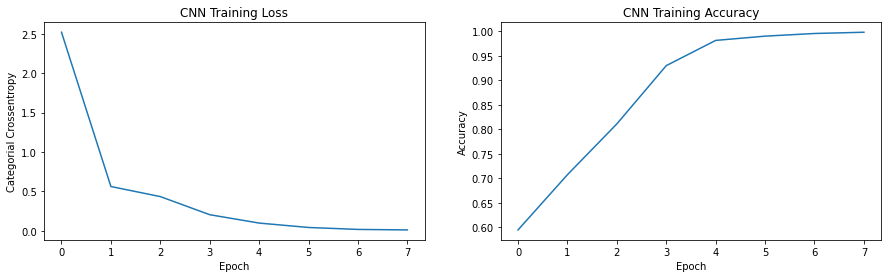

In [43]:
# Plot training progress
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(history.history["loss"])
axs[0].set_title("CNN Training Loss")
axs[0].set_ylabel("Categorial Crossentropy")
axs[0].set_xlabel("Epoch")
axs[1].plot(history.history["accuracy"])
axs[1].set_title("CNN Training Accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")

In [44]:
# Evaluate on test set
cnn.evaluate(x_test, y_test)

29/29 [==============================] - 0s 4ms/step - loss: 1.2691 - accuracy: 0.6913


[1.269088864326477, 0.6913043260574341]